In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
# Code was showing some warnings, from stack overflow optimal answer was to include this
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df= pd.read_csv("fetal_health.csv")

In [3]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
X = df.iloc[:, :-1]  
y = df.iloc[:, -1]   


## Splitting & Using GB


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:

lgb_classifier = lgb.LGBMClassifier()

lgb_classifier.fit(X_train, y_train)
y_pred = lgb_classifier.predict(X_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1208
[LightGBM] [Info] Number of data points in the train set: 1700, number of used features: 20
[LightGBM] [Info] Start training from score -0.251483
[LightGBM] [Info] Start training from score -1.995966
[LightGBM] [Info] Start training from score -2.447951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Using Evaluation Metrics

Accuracy =  95.77464788732394 %
Precision =  0.9509005076470398
Recall =  0.9189221549135342
F1-score =  0.9343167979561423


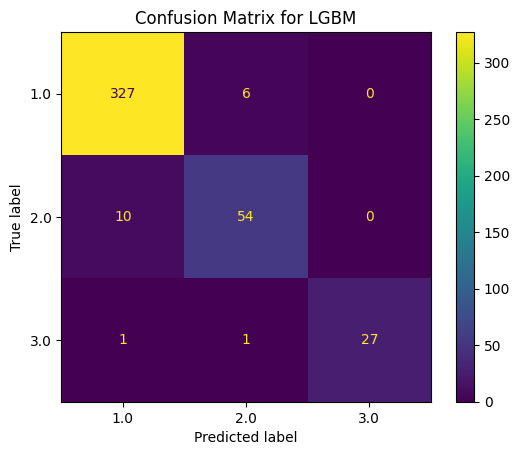

Classification Report
              precision    recall  f1-score   support

         1.0       0.97      0.98      0.97       333
         2.0       0.89      0.84      0.86        64
         3.0       1.00      0.93      0.96        29

    accuracy                           0.96       426
   macro avg       0.95      0.92      0.93       426
weighted avg       0.96      0.96      0.96       426



In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Calculating using average macro
print("Accuracy = ", accuracy_score(y_test, y_pred) * 100, "%")
print("Precision = ", precision_score(y_test, y_pred,average='macro'))
print("Recall = ", recall_score(y_test, y_pred,average='macro'))
print("F1-score = ", f1_score(y_test, y_pred,average='macro'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=np.unique(y))
disp.plot()
plt.title('Confusion Matrix for LGBM')
plt.show()
# Using classification report too
print("Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


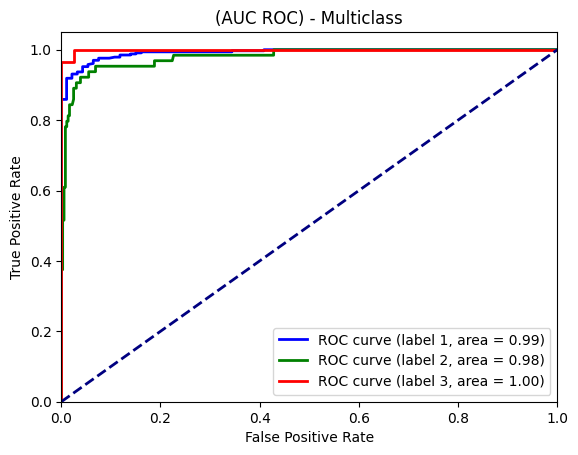

In [8]:
# For multiclass

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
y_scores = lgb_classifier.predict_proba(X_test)

plt.figure()

n_classes = 3
colors = ['b', 'g', 'r']

for i in range(1, n_classes + 1):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i - 1], y_scores[:, i - 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i - 1], lw=2, label=f'ROC curve (label {i}, area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(AUC ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()


In [9]:
# train_sizes, train_scores, test_scores = learning_curve(lgb_classifier, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

# plt.figure()
# plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
# plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
# plt.xlabel("Training examples")
# plt.ylabel("Score")
# plt.title("Learning Curve")
# plt.legend(loc="best")
# plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1208
[LightGBM] [Info] Number of data points in the train set: 1700, number of used features: 20
[LightGBM] [Info] Start training from score 1.308824
Feature importance:
abnormal_short_term_variability: 355
percentage_of_time_with_abnormal_long_term_variability: 292
histogram_width: 230
baseline value: 217
histogram_mean: 206
histogram_variance: 172
mean_value_of_short_term_variability: 171
histogram_min: 166
histogram_max: 157
mean_value_of_long_term_variability: 143
histogram_mode: 140
histogram_median: 129
accelerations: 118
uterine_contractions: 111
prolongued_decelerations: 103
fetal_movement: 103
histogram_number_of_peaks: 102
light_decelerations: 56
histogram_tendency: 24
histogram_number_of_zeroes: 5
severe_dece

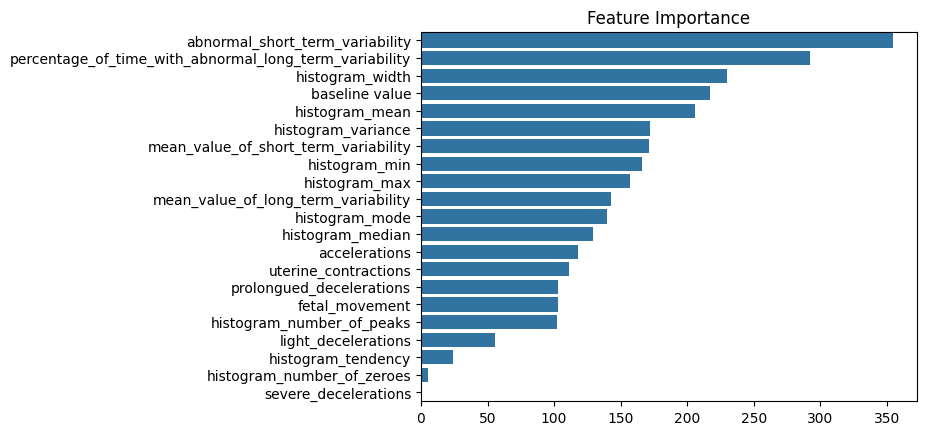

In [10]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv("fetal_health.csv")

# Separate features (X) and target variable (y)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Set up the parameters for the LightGBM model
params = {
    "objective": "regression",  # or "classification" based on your task
    "metric": "mse",  # or other appropriate metric
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9
}

# Train the LightGBM model
num_round = 100
bst = lgb.train(params, train_data, num_round)

# Calculate feature importance
feature_importance = bst.feature_importance(importance_type='split')  # or 'gain' for gain-based importance

# Map feature names to their indices
feature_names = X.columns
feature_indices = dict(zip(range(len(feature_names)), feature_names))

# Sort features by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Print feature importance
print("Feature importance:")
for idx in sorted_idx:
    print(f"{feature_indices[idx]}: {feature_importance[idx]}")

# Plot feature importance
sns.barplot(x=feature_importance[sorted_idx], y=[feature_indices[idx] for idx in sorted_idx])
plt.title("Feature Importance")
plt.show()


## Checking class distribution

Class Distribution:
fetal_health
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64
Coefficient of Variation (CV): 1.1595095195631708


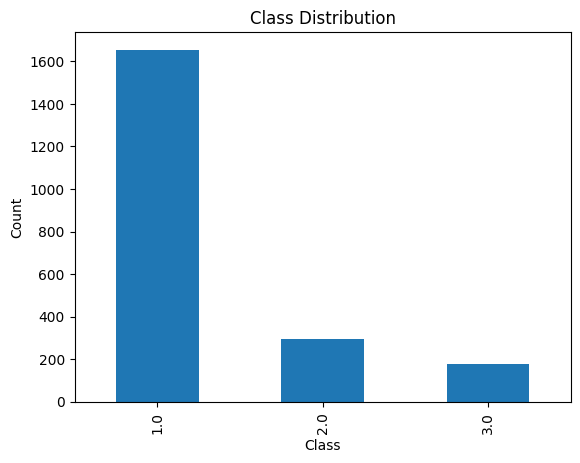

In [11]:

target_column = 'fetal_health'

class_distribution = df[target_column].value_counts()

mean_class_size = class_distribution.mean()
std_class_size = class_distribution.std()
imbalance_cv = std_class_size / mean_class_size

print(f"Class Distribution:\n{class_distribution}")
print(f"Coefficient of Variation (CV): {imbalance_cv}")

class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [12]:
top_k_features_indices = sorted_idx[:16]
print("Indices of Important Features:", top_k_features_indices)

X_selected = X.iloc[:, top_k_features_indices]

Indices of Important Features: [ 7  9 11  0 17 19  8 12 13 10 16 18  1  3  6  2]


## Applying SMOTE


In [13]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Apply SMOTE only on the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)




Class Distribution:
fetal_health
1.0    1322
2.0    1322
3.0    1322
Name: count, dtype: int64
Coefficient of Variation (CV): 0.0


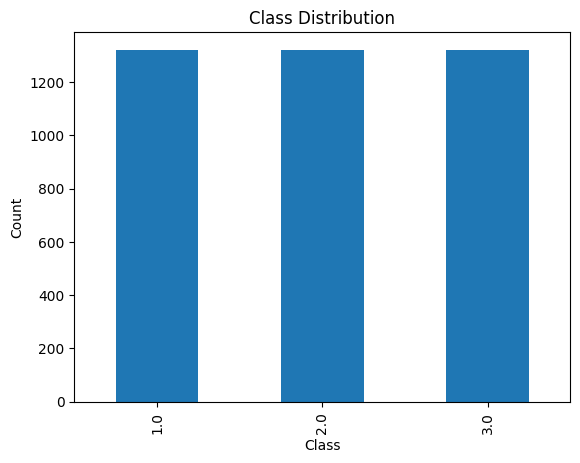

In [14]:


class_distribution = y_resampled.value_counts()

mean_class_size = class_distribution.mean()
std_class_size = class_distribution.std()
imbalance_cv = std_class_size / mean_class_size

print(f"Class Distribution:\n{class_distribution}")
print(f"Coefficient of Variation (CV): {imbalance_cv}")

class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## Using GB

In [15]:


from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.model_selection import cross_val_score, KFold


lgb_classifier_after = lgb.LGBMClassifier()

lgb_classifier_after.fit(X_resampled, y_resampled)

y_pred_full = lgb_classifier_after.predict(X_resampled)
y_pred_test = lgb_classifier_after.predict(X_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4069
[LightGBM] [Info] Number of data points in the train set: 3966, number of used features: 16
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Using Evaluation Metrics

Metrics on Resampled Training Set:
Accuracy (Resampled): 1.0
Precision (macro, Resampled): 1.0
Recall (macro, Resampled): 1.0
F1-score (macro, Resampled): 1.0


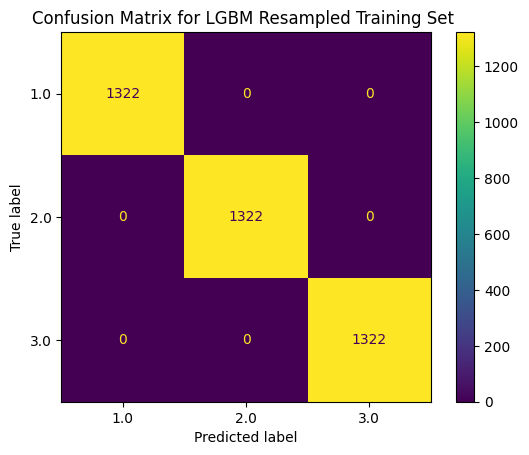


Metrics on Test Set:
Test Accuracy: 0.9553990610328639
Test Precision (macro): 0.9228706492637215
Test Recall (macro): 0.9326217381174278
Test F1-score (macro): 0.9276545441994818


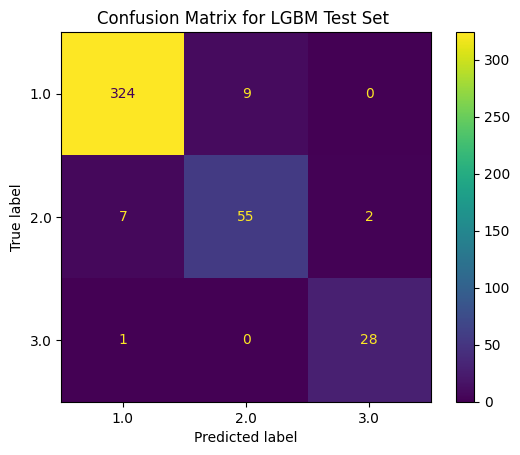

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Evaluate on the resampled training set
accuracy_resampled = accuracy_score(y_resampled, y_pred_full)
precision_resampled = precision_score(y_resampled, y_pred_full, average='macro')
recall_resampled = recall_score(y_resampled, y_pred_full, average='macro')
f1_resampled = f1_score(y_resampled, y_pred_full, average='macro')

conf_matrix_resampled = confusion_matrix(y_resampled, y_pred_full)

print("Metrics on Resampled Training Set:")
print("Accuracy (Resampled):", accuracy_resampled)
print("Precision (macro, Resampled):", precision_resampled)
print("Recall (macro, Resampled):", recall_resampled)
print("F1-score (macro, Resampled):", f1_resampled)

# Display confusion matrix for resampled training set
disp_resampled = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_resampled, display_labels=np.unique(y))
disp_resampled.plot()
plt.title('Confusion Matrix for LGBM Resampled Training Set ')
plt.show()

# Evaluate on the original test set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='macro')
recall_test = recall_score(y_test, y_pred_test, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')

conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print("\nMetrics on Test Set:")
print("Test Accuracy:", accuracy_test)
print("Test Precision (macro):", precision_test)
print("Test Recall (macro):", recall_test)
print("Test F1-score (macro):", f1_test)

# Display confusion matrix for test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=np.unique(y))
disp_test.plot()
plt.title('Confusion Matrix for LGBM Test Set ')
plt.show()


## K fold

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform K-Fold cross-validation
for train_index, val_index in kf.split(X_selected, y):
    X_train_fold, X_val_fold = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Apply SMOTE only on the training fold
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled_fold, y_resampled_fold = smote.fit_resample(X_train_fold, y_train_fold)

    # Train the LightGBM classifier
    lgb_classifier_fold = lgb.LGBMClassifier()
    lgb_classifier_fold.fit(X_resampled_fold, y_resampled_fold)

    # Predict on the validation fold
    y_pred_val = lgb_classifier_fold.predict(X_val_fold)

    # Evaluate the model
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred_val))
    precision_scores.append(precision_score(y_val_fold, y_pred_val, average='weighted'))
    recall_scores.append(recall_score(y_val_fold, y_pred_val, average='weighted'))
    f1_scores.append(f1_score(y_val_fold, y_pred_val, average='weighted'))

# Calculate average evaluation metrics
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)

print("Average Accuracy:", avg_accuracy)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4073
[LightGBM] [Info] Number of data points in the train set: 3966, number of used features: 16
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4077
[LightGBM] [Info] Number of data points in the train se

## Stratified K fold

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform Stratified K-Fold cross-validation
for train_index, val_index in skf.split(X_selected, y):
    X_train_fold, X_val_fold = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Apply SMOTE only on the training fold
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled_fold, y_resampled_fold = smote.fit_resample(X_train_fold, y_train_fold)

    # Train the LightGBM classifier
    lgb_classifier_fold = lgb.LGBMClassifier()
    lgb_classifier_fold.fit(X_resampled_fold, y_resampled_fold)

    # Predict on the validation fold
    y_pred_val = lgb_classifier_fold.predict(X_val_fold)

    # Evaluate the model
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred_val))
    precision_scores.append(precision_score(y_val_fold, y_pred_val, average='weighted'))
    recall_scores.append(recall_score(y_val_fold, y_pred_val, average='weighted'))
    f1_scores.append(f1_score(y_val_fold, y_pred_val, average='weighted'))

# Calculate average evaluation metrics
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)

print("Average Accuracy:", avg_accuracy)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4073
[LightGBM] [Info] Number of data points in the train set: 3972, number of used features: 16
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4077
[LightGBM] [Info] Number of data points in the train set: 3972, number of used features: 16
[LightGBM] [Info] Start tra

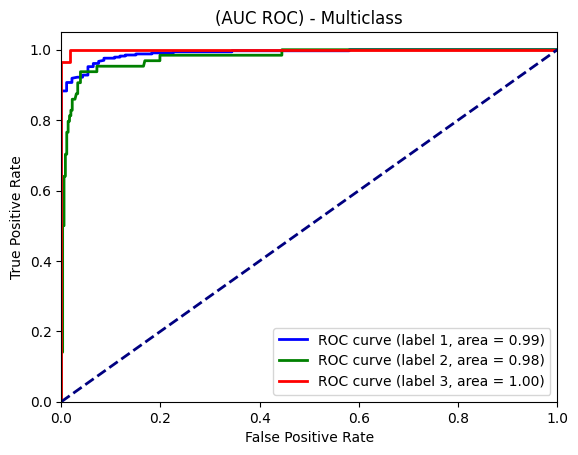

In [19]:
# For multiclass

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
y_scores = lgb_classifier_after.predict_proba(X_test)


plt.figure()

n_classes = 3
colors = ['b', 'g', 'r']

for i in range(1, n_classes + 1):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i - 1], y_scores[:, i - 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i - 1], lw=2, label=f'ROC curve (label {i}, area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(AUC ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 19
[LightGBM] [Info] Start training from score -1.498212
[LightGBM] [Info] Start training from score -0.356675
[LightGBM] [Info] Start training from score -2.570849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

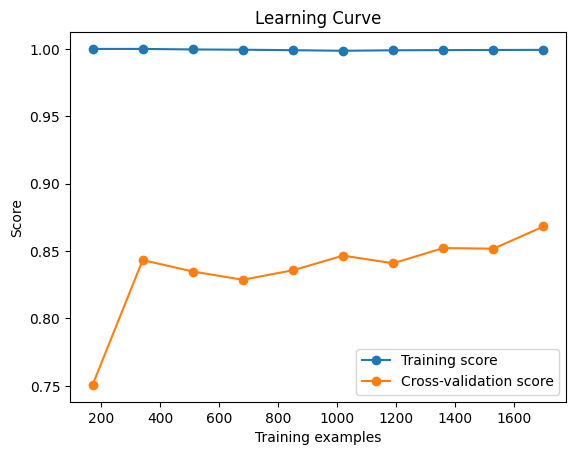

In [20]:
train_sizes, train_scores, test_scores = learning_curve(lgb_classifier_after, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1208
[LightGBM] [Info] Number of data points in the train set: 1700, number of used features: 20
[LightGBM] [Info] Start training from score 1.308824
Feature importance:
abnormal_short_term_variability: 355
percentage_of_time_with_abnormal_long_term_variability: 292
histogram_width: 230
baseline value: 217
histogram_mean: 206
histogram_variance: 172
mean_value_of_short_term_variability: 171
histogram_min: 166
histogram_max: 157
mean_value_of_long_term_variability: 143
histogram_mode: 140
histogram_median: 129
accelerations: 118
uterine_contractions: 111
prolongued_decelerations: 103
fetal_movement: 103
histogram_number_of_peaks: 102
light_decelerations: 56
histogram_tendency: 24
histogram_number_of_zeroes: 5
severe_dece

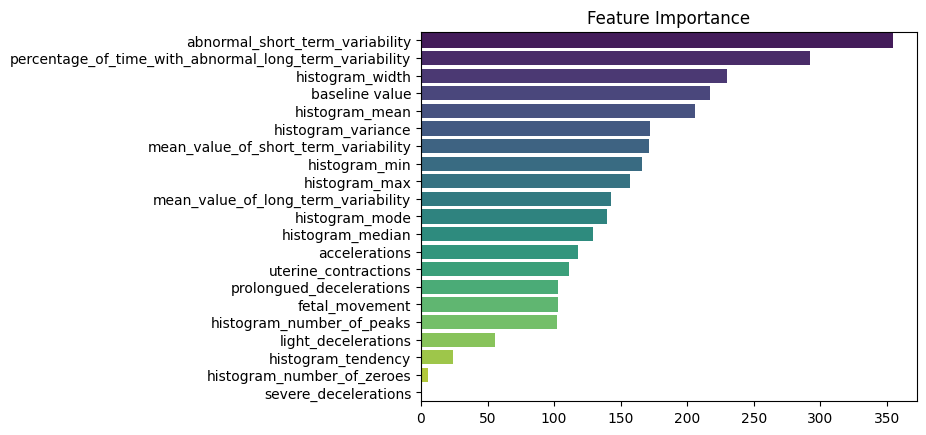

In [21]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv("fetal_health.csv")

# Separate features (X) and target variable (y)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Set up the parameters for the LightGBM model
params = {
    "objective": "regression",  # or "classification" based on your task
    "metric": "mse",  # or other appropriate metric
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9
}

# Train the LightGBM model
num_round = 100
bst = lgb.train(params, train_data, num_round)

# Calculate feature importance
feature_importance = bst.feature_importance(importance_type='split')  # or 'gain' for gain-based importance

# Map feature names to their indices
feature_names = X.columns
feature_indices = dict(zip(range(len(feature_names)), feature_names))

# Sort features by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Print feature importance
print("Feature importance:")
for idx in sorted_idx:
    print(f"{feature_indices[idx]}: {feature_importance[idx]}")

# Plot feature importance
sns.barplot(x=feature_importance[sorted_idx], y=[feature_indices[idx] for idx in sorted_idx], palette="viridis")
plt.title("Feature Importance")
plt.show()
